# Train smarter and longer (and now slower)

After the original "what am I feeding my network batch size and  video level accuracy. What I've seen is that it should be possible to reach a much higher level. In the com

In [1]:
import os
import sys


up1 = os.path.abspath('../../utils/') 
up2 = os.path.abspath('../../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow
from motion_network import getKerasCifarMotionModel2, getKerasCifarMotionModelOnly
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from keras.optimizers import SGD
import cv2 
import numpy as np
import keras

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


# Is it the data or my classifier

I am starting to wonder what it is about my optical flow data that might be causing so much easier. Regardless about the unconverged flow images I feel the author of the data still managed with it. So there's essentially two things I can either get a large amount of improvement simply on how I train my classifier (slower?), or my data set is not quite right. I've already seen that I wasn't even doing any random transforms on my opt flow images courtesy my badly written opt flow data generator. 
Any how what I am aiming to do is use a stinkingly cheap data model to explore what might be wrong. 

In [3]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.initializers import Ones
from keras import optimizers

def getModel(lr=1e-2):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 2)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('sigmoid'))

    optimizers.SGD(lr=lr)
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [8]:
from optical_flow_data_gen import DataGenerator
from ucf101_data_utils import get_test_data_opt_flow, get_train_data_opt_flow

training_options = { 'rescale' : 1./255, 
                     'samplewise_center': True, 
                         'samplewise_std_normalization':True,
                            'zoom_range' : 0.2, 
                            'horizontal_flip' : True}

validation_options = { 'rescale' : 1./255,
                     'samplewise_center': True, 
                         'samplewise_std_normalization':True}




params_train = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size': 128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : False,
                'enable_augmentation' : True,
               'training_opts' : training_options}

params_valid = { 'data_dir' : "/data/tvl1_flow",
          'dim': (224,224),
          'batch_size':128,
          'n_frames': 1,
          'n_frequency': 1,
          'shuffle': True, 
                'n_classes' : 10,
           'validation' : True,
               'validation_opts' : validation_options}

id_labels_train = get_train_data_opt_flow('../../data/ucf101_splits/trainlist01_small.txt')
labels = id_labels_train[1]
id_test = get_test_data_opt_flow('../../data/ucf101_splits/testlist01_small.txt', \
                       '../../data/ucf101_splits/classInd_small.txt')

training_generator = DataGenerator(*id_labels_train, **params_train)


validation_generator = DataGenerator(id_test[0], id_test[1], **params_valid)

In [9]:
model_slow_lr = getModel(1e-3)

In [10]:
mod1 = model_slow_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=60,
                    verbose=1)

Epoch 1/60
64/64 [==============================] - 110s 2s/step - loss: 2.2433 - acc: 0.1298 - val_loss: 2.2356 - val_acc: 0.1648
Epoch 2/60
64/64 [==============================] - 109s 2s/step - loss: 2.1934 - acc: 0.1945 - val_loss: 2.1868 - val_acc: 0.2393
Epoch 3/60
64/64 [==============================] - 106s 2s/step - loss: 2.1537 - acc: 0.2386 - val_loss: 2.1432 - val_acc: 0.2804
Epoch 4/60
64/64 [==============================] - 106s 2s/step - loss: 2.1085 - acc: 0.2618 - val_loss: 2.1546 - val_acc: 0.3082
Epoch 5/60
64/64 [==============================] - 107s 2s/step - loss: 2.0702 - acc: 0.2740 - val_loss: 2.0786 - val_acc: 0.3126
Epoch 6/60
64/64 [==============================] - 101s 2s/step - loss: 2.0304 - acc: 0.2803 - val_loss: 2.0734 - val_acc: 0.3093
Epoch 7/60
64/64 [==============================] - 107s 2s/step - loss: 2.0028 - acc: 0.2920 - val_loss: 2.0228 - val_acc: 0.3130
Epoch 8/60
64/64 [==============================] - 106s 2s/step - loss: 1.9861 - a

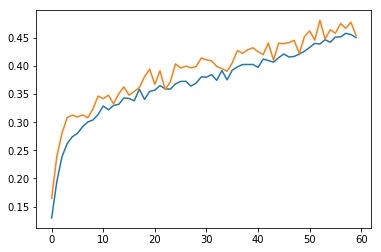

In [11]:
plt.plot(mod1.history['acc'])
plt.plot(mod1.history['val_acc'])

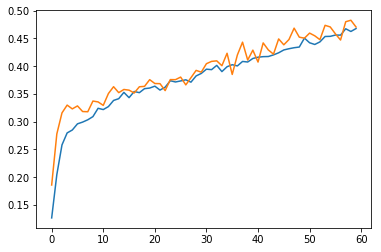

In [20]:
plt.plot(mod1.history['acc'])
plt.plot(mod1.history['val_acc'])

In [23]:
model_medium_lr.load_weights('../../data/weights/model_10_class_60_epochs.hdf5')

In [24]:
mod2 = model_medium_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=30,
                    verbose=1)

Epoch 1/30
64/64 [==============================] - 96s 1s/step - loss: 1.5367 - acc: 0.4744 - val_loss: 1.5528 - val_acc: 0.4875
Epoch 2/30
64/64 [==============================] - 93s 1s/step - loss: 1.5379 - acc: 0.4708 - val_loss: 1.5462 - val_acc: 0.4674
Epoch 3/30
64/64 [==============================] - 97s 2s/step - loss: 1.5236 - acc: 0.4724 - val_loss: 1.5063 - val_acc: 0.4943
Epoch 4/30
64/64 [==============================] - 96s 2s/step - loss: 1.5418 - acc: 0.4763 - val_loss: 1.5280 - val_acc: 0.4980
Epoch 5/30
64/64 [==============================] - 98s 2s/step - loss: 1.5237 - acc: 0.4824 - val_loss: 1.5245 - val_acc: 0.4872
Epoch 6/30
64/64 [==============================] - 95s 1s/step - loss: 1.5098 - acc: 0.4817 - val_loss: 1.5600 - val_acc: 0.4847
Epoch 7/30
64/64 [==============================] - 98s 2s/step - loss: 1.5232 - acc: 0.4818 - val_loss: 1.5332 - val_acc: 0.4865
Epoch 8/30
64/64 [==============================] - 93s 1s/step - loss: 1.5046 - acc: 0.48

In [25]:
model_medium_lr.save_weights('../../data/weights/model_10_class_90_epochs.hdf5')

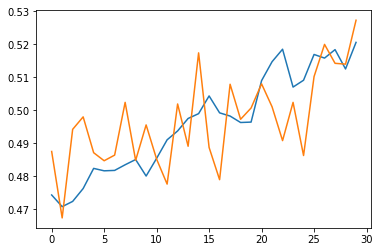

In [26]:
plt.plot(mod2.history['acc'])
plt.plot(mod2.history['val_acc'])

In [27]:
mod3 = model_medium_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=60,
                    verbose=1)

Epoch 1/60
64/64 [==============================] - 100s 2s/step - loss: 1.3962 - acc: 0.5232 - val_loss: 1.4287 - val_acc: 0.5076
Epoch 2/60
64/64 [==============================] - 91s 1s/step - loss: 1.3814 - acc: 0.5231 - val_loss: 1.4142 - val_acc: 0.5181
Epoch 3/60
64/64 [==============================] - 95s 1s/step - loss: 1.3819 - acc: 0.5270 - val_loss: 1.4334 - val_acc: 0.5085
Epoch 4/60
64/64 [==============================] - 93s 1s/step - loss: 1.3961 - acc: 0.5240 - val_loss: 1.4288 - val_acc: 0.5182
Epoch 5/60
64/64 [==============================] - 93s 1s/step - loss: 1.3721 - acc: 0.5239 - val_loss: 1.4442 - val_acc: 0.5233
Epoch 6/60
64/64 [==============================] - 95s 1s/step - loss: 1.3611 - acc: 0.5282 - val_loss: 1.4444 - val_acc: 0.5170
Epoch 7/60
64/64 [==============================] - 99s 2s/step - loss: 1.3809 - acc: 0.5231 - val_loss: 1.4120 - val_acc: 0.5271
Epoch 8/60
64/64 [==============================] - 95s 1s/step - loss: 1.3691 - acc: 0.5

In [28]:
model_medium_lr.save_weights('../../data/weights/model_10_class_150_epochs.hdf5')

In [29]:
model_fast_lr = getModel(lr=1e-2)
model_fast_lr.load_weights('../../data/weights/model_10_class_60_epochs.hdf5')

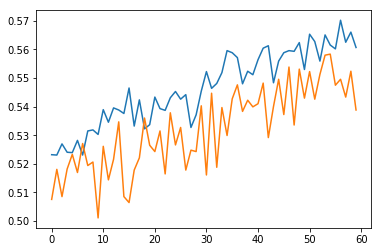

In [30]:
plt.plot(mod3.history['acc'])
plt.plot(mod3.history['val_acc'])

In [31]:
mod4 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=60,
                    verbose=1)

Epoch 1/60
64/64 [==============================] - 99s 2s/step - loss: 1.5569 - acc: 0.4662 - val_loss: 1.5662 - val_acc: 0.4839
Epoch 2/60
64/64 [==============================] - 92s 1s/step - loss: 1.5459 - acc: 0.4731 - val_loss: 1.5753 - val_acc: 0.4761
Epoch 3/60
64/64 [==============================] - 95s 1s/step - loss: 1.5153 - acc: 0.4791 - val_loss: 1.5475 - val_acc: 0.4855
Epoch 4/60
64/64 [==============================] - 93s 1s/step - loss: 1.5180 - acc: 0.4736 - val_loss: 1.5569 - val_acc: 0.4862
Epoch 5/60
64/64 [==============================] - 97s 2s/step - loss: 1.5076 - acc: 0.4851 - val_loss: 1.5313 - val_acc: 0.4757
Epoch 6/60
64/64 [==============================] - 92s 1s/step - loss: 1.4997 - acc: 0.4893 - val_loss: 1.5495 - val_acc: 0.4838
Epoch 7/60
64/64 [==============================] - 102s 2s/step - loss: 1.5260 - acc: 0.4790 - val_loss: 1.5409 - val_acc: 0.5013
Epoch 8/60
64/64 [==============================] - 94s 1s/step - loss: 1.4916 - acc: 0.4

In [32]:
model_fast_lr.save_weights('../../data/weights/model_10_class_120_fast_epochs.hdf5')

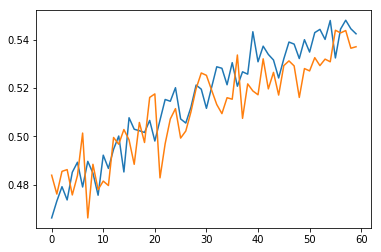

In [33]:
plt.plot(mod4.history['acc'])
plt.plot(mod4.history['val_acc'])

In [34]:
mod4 = model_fast_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=30,
                    verbose=1)

Epoch 1/30
64/64 [==============================] - 99s 2s/step - loss: 1.2988 - acc: 0.5524 - val_loss: 1.3771 - val_acc: 0.5387
Epoch 2/30
64/64 [==============================] - 99s 2s/step - loss: 1.2827 - acc: 0.5544 - val_loss: 1.3781 - val_acc: 0.5371
Epoch 3/30
64/64 [==============================] - 96s 1s/step - loss: 1.3194 - acc: 0.5482 - val_loss: 1.3851 - val_acc: 0.5444
Epoch 4/30
64/64 [==============================] - 95s 1s/step - loss: 1.2889 - acc: 0.5544 - val_loss: 1.3809 - val_acc: 0.5402
Epoch 5/30
64/64 [==============================] - 96s 2s/step - loss: 1.2899 - acc: 0.5485 - val_loss: 1.3635 - val_acc: 0.5406
Epoch 6/30
64/64 [==============================] - 101s 2s/step - loss: 1.3091 - acc: 0.5433 - val_loss: 1.3719 - val_acc: 0.5425
Epoch 7/30
64/64 [==============================] - 96s 2s/step - loss: 1.2899 - acc: 0.5515 - val_loss: 1.3429 - val_acc: 0.5516
Epoch 8/30
64/64 [==============================] - 94s 1s/step - loss: 1.3048 - acc: 0.5

In [35]:
model_fast_lr.save_weights('../../data/weights/model_10_class_150_fast_epochs.hdf5')

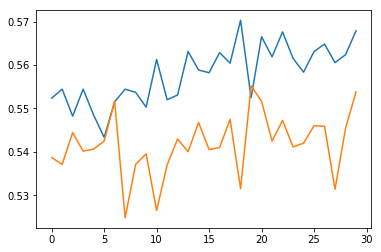

In [37]:
plt.plot(mod4.history['acc'])
plt.plot(mod4.history['val_acc'])

In [7]:
model_medium_lr.load_weights('../../data/weights/model_10_class_150_epochs.hdf5')

In [8]:
mod1 = model_medium_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=60,
                    verbose=1)

Epoch 1/60
64/64 [==============================] - 177s 3s/step - loss: 1.2572 - acc: 0.5693 - val_loss: 1.3387 - val_acc: 0.5579
Epoch 2/60
64/64 [==============================] - 111s 2s/step - loss: 1.2252 - acc: 0.5730 - val_loss: 1.3225 - val_acc: 0.5618
Epoch 3/60
64/64 [==============================] - 114s 2s/step - loss: 1.2333 - acc: 0.5767 - val_loss: 1.3302 - val_acc: 0.5575
Epoch 4/60
64/64 [==============================] - 111s 2s/step - loss: 1.2390 - acc: 0.5718 - val_loss: 1.3346 - val_acc: 0.5488
Epoch 5/60
64/64 [==============================] - 109s 2s/step - loss: 1.2206 - acc: 0.5787 - val_loss: 1.3411 - val_acc: 0.5502
Epoch 6/60
64/64 [==============================] - 110s 2s/step - loss: 1.2309 - acc: 0.5742 - val_loss: 1.3249 - val_acc: 0.5553
Epoch 7/60
64/64 [==============================] - 111s 2s/step - loss: 1.2473 - acc: 0.5665 - val_loss: 1.3214 - val_acc: 0.5586
Epoch 8/60
64/64 [==============================] - 108s 2s/step - loss: 1.2311 - a

Process ForkPoolWorker-2869:
Process ForkPoolWorker-2870:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu

KeyboardInterrupt: 

In [9]:
model_medium_lr.save_weights('../../data/weights/model_10_class_195_interrrupted_epochs.hdf5')

In [6]:
model_medium_lr.load_weights('../../data/weights/model_10_class_195_interrrupted_epochs.hdf5')

In [7]:
mod1 = model_medium_lr.fit_generator(generator=training_generator, steps_per_epoch=64,
                    validation_data=validation_generator, validation_steps=64,
                    use_multiprocessing=True,
                    workers=2, epochs=60,
                    verbose=1)

Epoch 1/60
64/64 [==============================] - 164s 3s/step - loss: 1.1524 - acc: 0.5953 - val_loss: 1.3251 - val_acc: 0.5610
Epoch 2/60
64/64 [==============================] - 101s 2s/step - loss: 1.1600 - acc: 0.5923 - val_loss: 1.3199 - val_acc: 0.5570
Epoch 3/60
64/64 [==============================] - 102s 2s/step - loss: 1.1587 - acc: 0.5963 - val_loss: 1.2819 - val_acc: 0.5699
Epoch 4/60
64/64 [==============================] - 102s 2s/step - loss: 1.1657 - acc: 0.6006 - val_loss: 1.2819 - val_acc: 0.5704
Epoch 5/60
64/64 [==============================] - 104s 2s/step - loss: 1.1455 - acc: 0.5958 - val_loss: 1.2945 - val_acc: 0.5664
Epoch 6/60
64/64 [==============================] - 100s 2s/step - loss: 1.1555 - acc: 0.5952 - val_loss: 1.3110 - val_acc: 0.5649
Epoch 7/60
64/64 [==============================] - 101s 2s/step - loss: 1.1524 - acc: 0.5980 - val_loss: 1.3020 - val_acc: 0.5679
Epoch 8/60
64/64 [==============================] - 98s 2s/step - loss: 1.1515 - ac

In [8]:
model_medium_lr.save_weights('../../data/weights/model_10_class_255_epochs.hdf5')

In [10]:
type(mod1.history['acc'])

list